In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import geopandas as gpd
import folium


In [2]:
pip install geopandas folium


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/323.6 kB ? eta -:--:--
   ------------- -------------------------- 112.6/323.6 kB 3.3 MB/s eta 0:00:01
   ----------------------------------- ---- 286.7/323.6 kB 3.5 MB/s eta 0:00:01
   ---------------------------------------  317.4/323.6 kB 2.5 MB/s eta 0:00:01
   ---------------------------------------- 323.6/323.6 kB 2.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/110.5 kB ? eta -:--:--
   ---------------------------------------- 110.5/110.5 kB 3.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/16.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.2 MB 2.0 MB/s eta 0:00:08
   ---------------------------------------- 0.1/16.2 MB 980.4 kB/s eta 0:00:17
    --------------------------------------- 0.3/16.2 MB 2.5 MB/s eta 0:00:07
    --------------------------------------- 0.4/16.2 MB 2.0 MB/s eta 0:00:08


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
def load_data():
    balance_data = pd.read_excel("Updated file AQI.xlsx")
    return balance_data

In [3]:
def preprocess_data(df):
    """Prepare the dataset for forecasting by grouping data by State and Year."""
    df_forecast = df.groupby(['State', 'year']).agg({'Number of Hospitals2': 'mean'}).reset_index()
    df_forecast['year'] = pd.to_datetime(df_forecast['year'], format='%Y')
    return df_forecast

In [4]:
def train_forecasting_models(df_forecast, future_years=10):
    """Train Exponential Smoothing models for each state and predict future hospital needs."""
    state_forecasts = {}
    
    for state in df_forecast['State'].unique():
        state_data = df_forecast[df_forecast['State'] == state].copy()
        
        # Fit Exponential Smoothing model
        model = ExponentialSmoothing(state_data['Number of Hospitals2'], trend='add', seasonal=None, damped_trend=True)
        model_fit = model.fit()
        
        # Predict future values
        future_index = pd.date_range(start=state_data['year'].max(), periods=future_years + 1, freq='Y')[1:]
        forecast_values = model_fit.forecast(steps=future_years)
        
        # Store results
        forecast_df = pd.DataFrame({'State': state, 'Year': future_index, 'Predicted_Hospitals': forecast_values})
        state_forecasts[state] = forecast_df
    
    return pd.concat(state_forecasts.values(), ignore_index=True)

In [5]:
def visualize_forecast(forecast_df):
    """Plot forecasted hospital needs for each state over the years."""
    plt.figure(figsize=(12, 6))
    
    for state in forecast_df['State'].unique():
        state_data = forecast_df[forecast_df['State'] == state]
        plt.plot(state_data['Year'], state_data['Predicted_Hospitals'], label=state)
    
    plt.xlabel("Year")
    plt.ylabel("Predicted Number of Hospitals")
    plt.title("Forecasted Hospital Demand by State")
    plt.legend()
    plt.grid(True)
    plt.show()

In [15]:
def visualize_on_map(forecast_df, india_shapefile):
    """Visualize hospital demand trends on an Indian map using Folium."""
    india_map = gpd.read_file(india_shapefile)
    india_map = india_map.merge(forecast_df.groupby('State').mean().reset_index(), left_on="STATE", right_on="State")
    
    m = folium.Map(location=[23.5937, 78.9629], zoom_start=5)
    
    for _, row in india_map.iterrows():
        folium.CircleMarker(
            location=[row["Latitude"], row["Longitude"]],
            radius=row["Predicted_Hospitals"] * 0.0001,
            color="red",
            fill=True,
            fill_color="red",
            fill_opacity=0.6,
        ).add_to(m)
    
    m.save("hospital_forecast_map.html")
    print("Map saved as hospital_forecast_map.html")

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index

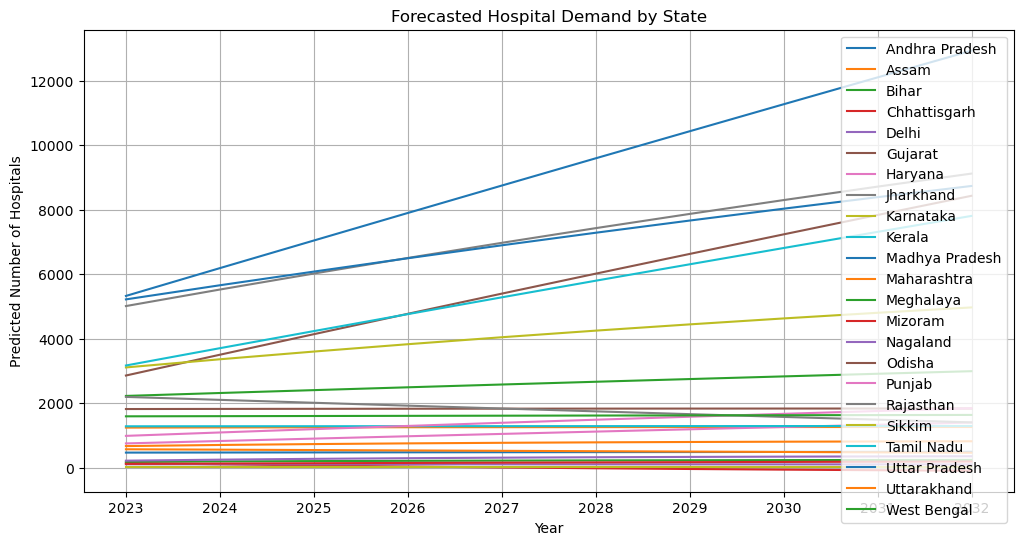

Map saved as hospital_forecast_map.html


C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\pyogrio\geopandas.py:265: UserWarning: More than one layer found in 'India Shape': 'india_ds' (default), 'india_st'. Specify layer parameter to avoid this warning.
  result = read_func(


In [19]:
# Main execution
if __name__ == "__main__":
    
    
    df = load_data()
    df_forecast = preprocess_data(df)
    forecast_results = train_forecasting_models(df_forecast)
    
    visualize_forecast(forecast_results)
    
    
    india_shapefile = r"C:\Users\Lenovo\Desktop\Trim3\Machine Learning\AP\India Shape"
    visualize_on_map(forecast_results, india_shapefile)
